# 심화 학습 : 다양체 학습

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 다양체 학습 : 'HELLO'

In [2]:
def make_hello(N = 1000, rseed = 42):
    # "HELLO" 텍스트로 플로팅해서 PNG 파일로 저장
    fig, ax = plt.subplots(figsize = (4, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va = 'center', ha = 'center', weight = 'bold', size = 85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # 이 PNG 파일을 열어 임의의 점을 추출
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

(-0.1089571412684307,
 4.1303023353895725,
 0.0447585776140384,
 0.9990273515924064)

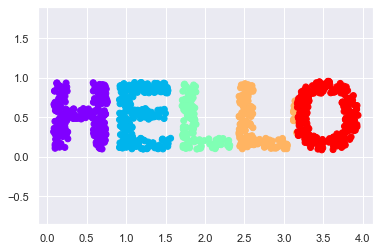

In [3]:
X = make_hello(1000)
colorize = dict(c = X[:, 0], cmap = plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal')

## 다차원 척도법(MDS, Multidimensional Scaling)

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

(4.607715441204515, 8.745900824125954, 5.035821528466808, 7.243272110369881)

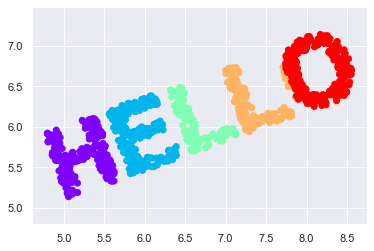

In [5]:
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal')

In [6]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

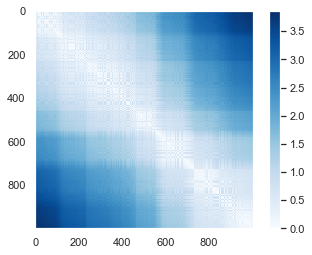

In [7]:
plt.imshow(D, zorder = 2, cmap = 'Blues', interpolation = 'nearest')
plt.colorbar()

In [8]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

(-1.0291497799483857,
 1.0278567681719433,
 -2.04948940500963,
 2.1202816440434114)

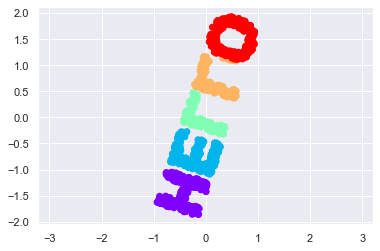

In [9]:
from sklearn.manifold import MDS
model = MDS(n_components = 2, dissimilarity = 'precomputed', random_state = 1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')

## 다양체 학습으로서의 MDS

In [10]:
def random_projection(X, dimension = 3, rseed = 42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

In [11]:
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

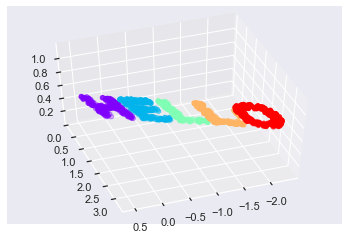

In [12]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection = '3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize)
ax.view_init(azim = 70, elev = 50)

(-1.0291497799483846,
 1.0278567681719428,
 -2.0494894050096297,
 2.1202816440434122)

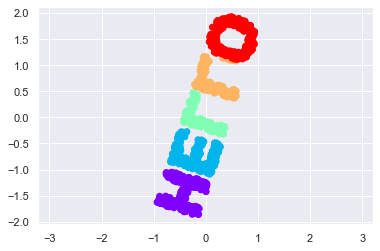

In [13]:
model = MDS(n_components = 2, random_state = 1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal')

## 비선형 임베딩 : MDS가 실패한 경우

In [14]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

In [15]:
XS = make_hello_s_curve(X)

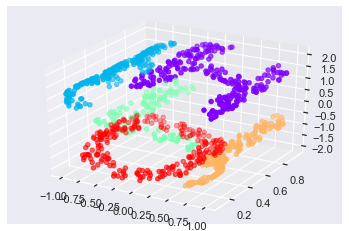

In [16]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection = '3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize)

(-1.3805990015310623,
 1.2395071320261248,
 -2.370372817724411,
 2.174809311914056)

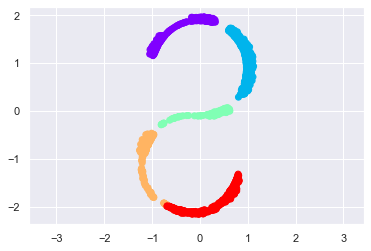

In [17]:
from sklearn.manifold import MDS
model = MDS(n_components = 2, random_state = 2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal')

## 비선형 다양체 학습 : 국소 선형 임베딩

In [18]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors = 100, n_components = 2, method = 'modified', eigen_solver = 'dense')
out = model.fit_transform(XS)

(0.15, -0.15)

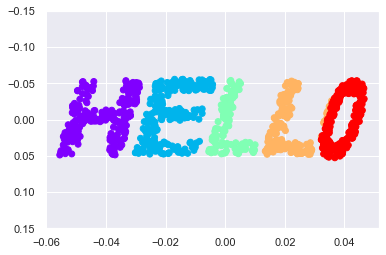

In [19]:
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15)

## 다양체 정리

1. PCA와 비교하였을 때, 다양체 학습이 가지는 취약점
    * 다양체 학습에는 누락된 데이터를 처리하는 좋은 프레임워크가 없다. 반면, PCA에는 누락된 데이터에 대한 간단하고 반복적인 접근 방식이 있다.
    * 다양체 학습에서는 데이터에 노이즈가 존재하면 다양체를 '단락(short-circuit)'시켜서 임베딩이 대폭 변경될 수 있다. 반면, PCA는 자연적으로 가장 중요한 성분으로부터 노이즈를 걸러낸다.
    * 다양체 임베딩 결과는 일반적으로 아웃의 수를 얼마로 선택하느냐에 따라 크게 달라지며 보통 적절한 이웃의 수를 선택하기 위한 믿을 만한 정량적 방법이 없다. 반면, PCA는 그러한 선택이 필요 없다.
    * 다양체 학습에서는 전역적으로 결과 차원의 최적의 개수를 정하기가 어렵다. 반면, PCA는 설명 분삭을 기반으로 결과 차원을 구할 수 있다.
    * 다양체 학습에서는 임베딩된 차원이 의미하는 바가 항상 분명하지 않다. PCA에서는 주성분이 매우 분명한 의미를 가진다.
    * 다양체 학습에서 다양체 기법의 계산 비용은 O[N^2]나 O[N^3]에 달한다. PCA의 경우 일반적으로 훨씬 더 빠른 임의화된 방식이 존재한다.<br><br>
2. 다양체 학습의 장점
    * 데이터의 비선형 관계를 보존할 수 있다.
    * 따라서, PCA로 데이터를 확인한 다음에만 다양체 기법으로 탐색하는 것이 좋다.

## 예제 : 얼굴 데이터에 아이소맵 적용

In [20]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person = 30)
faces.data.shape

(2370, 2914)

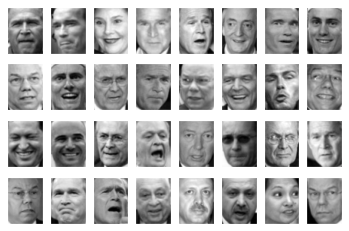

In [21]:
fig, ax = plt.subplots(4, 8, subplot_kw = dict(xticks = [], yticks = []))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap = 'gray')

Text(0, 0.5, 'cumulative variance')

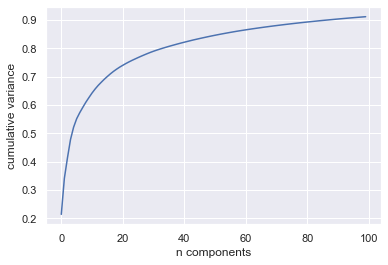

In [22]:
from sklearn.decomposition import PCA
model = PCA(100, svd_solver = 'randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')

In [23]:
from sklearn.manifold import Isomap
model = Isomap(n_components = 2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [24]:
from matplotlib import offsetbox

def plot_components(data, model, images = None, ax = None, thumb_frac = 0.05, cmap = 'gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # 너무 가까운 점들은 보여주지 말 것
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap = cmap), proj[i])
            ax.add_artist(imagebox)

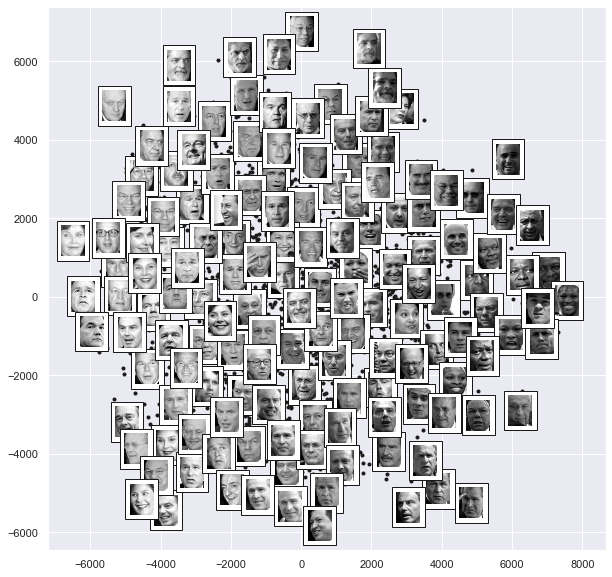

In [25]:
fig, ax = plt.subplots(figsize = (10, 10))
plot_components(faces.data, model = Isomap(n_components = 2), images = faces.images[:, ::2, ::2])

## 예제 : 숫자 데이터의 구조 시각화

In [26]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [27]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8)
    sort_by_target(mnist)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [28]:
mnist.data.shape

(70000, 784)

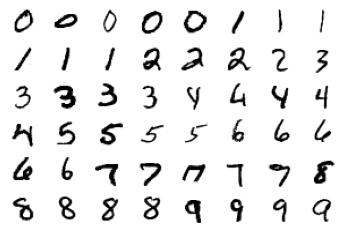

In [29]:
fig, ax = plt.subplots(6, 8, subplot_kw = dict(xticks = [], yticks = []))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap = 'gray_r')

In [30]:
# 데이터의 1/30 사용. 전체 데이터 세트를 계산하려면 시간이 오래 걸림
data = mnist.data[::30]
target = mnist.target[::30]

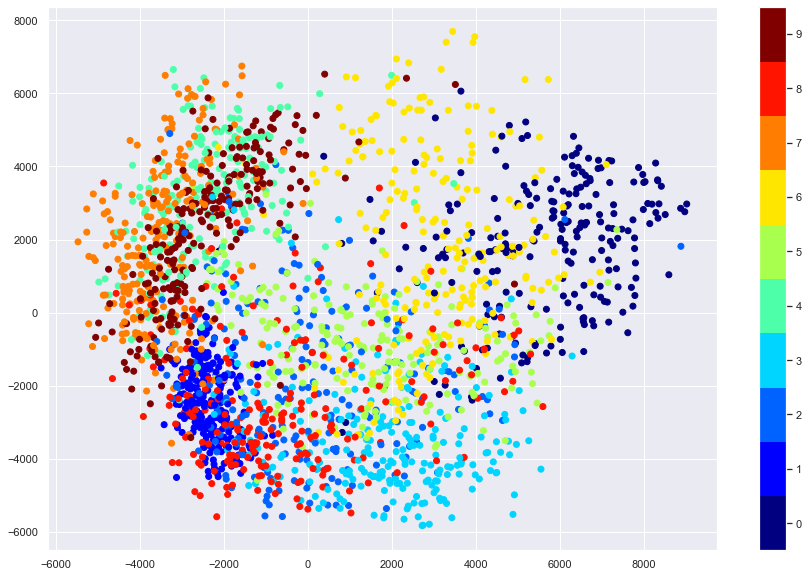

In [31]:
model = Isomap(n_components = 2)
proj = model.fit_transform(data)
plt.figure(figsize = (15, 10))
plt.scatter(proj[:, 0], proj[:, 1], c = target, cmap = plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks = range(10))
plt.clim(-0.5, 9.5)

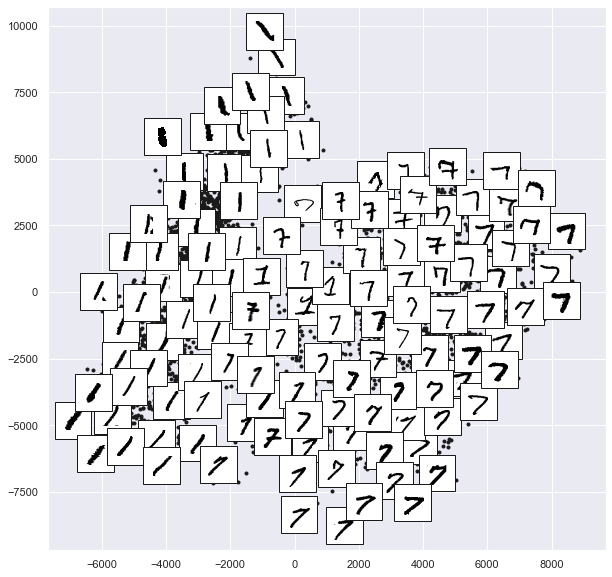

In [32]:
from sklearn.manifold import Isomap

# 사영할 숫자 '1' or '7'의 1/4을 선택
data = mnist.data[(mnist.target == 1) | (mnist.target == 7)][::4]

fig, ax = plt.subplots(figsize = (10, 10))
model = Isomap(n_neighbors = 5, n_components = 2, eigen_solver = 'dense')
plot_components(data, model, images = data.reshape((-1, 28, 28)), ax = ax, thumb_frac = 0.05, cmap = 'gray_r')